In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam
import torch
import matplotlib.pyplot as plt
import random
from core.mssim import MSSSIM
from core.load_data import LoadTrainData
from core.mwcnn_model import MWRCAN, Discriminator
from core.vgg import vgg_19
from core.utils import normalize_batch, BaseOptions
import os
from tqdm import tqdm
import math

In [2]:
#!wget https://download.pytorch.org/models/vgg19-dcbb9e9d.pth

In [3]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

In [6]:
from core.load_data import LoadTrainData

base_dir = "/home/gosha20777/Documents/Datasets/uda/mai-rgb/test"
base_dir = "/home/gosha20777/Documents/Datasets/uda/mai-rgb/test"
train_input_dir = os.path.join(base_dir, "raw")
train_target_dir = os.path.join(base_dir, "rgb")
img_size = (126, 126)
input_channels = 3
output_channels = 3
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png")
    ]
)


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))
    
val_samples = 570
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_dataset = LoadTrainData(train_input_img_paths, train_target_img_paths)
test_dataset = LoadTrainData(val_input_img_paths, val_target_img_paths, test=True)

print("Number of samples:", len(input_img_paths))
print("Number train batches:", len(train_dataset))
print("Number val batches:", len(test_dataset))

0.png | 0.png
1.png | 1.png
10.png | 10.png
100.png | 100.png
101.png | 101.png
102.png | 102.png
103.png | 103.png
104.png | 104.png
105.png | 105.png
106.png | 106.png
Number of samples: 462
Number train batches: 0
Number val batches: 462


In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=12,
                              pin_memory=True, drop_last=True)
val_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=1,
                            pin_memory=True, drop_last=True)

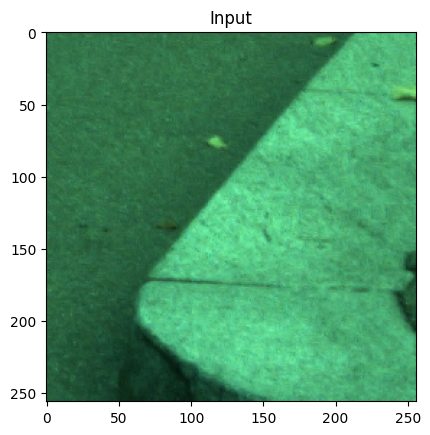

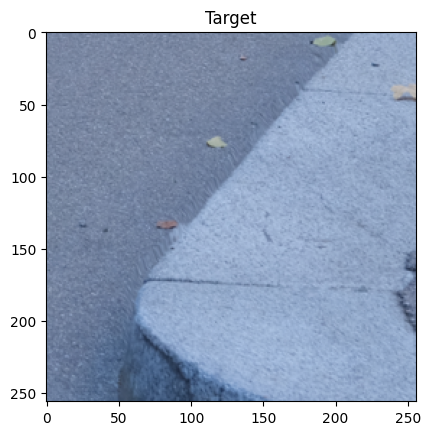

In [9]:
batch = next(iter(val_loader))
batch_input, batch_target = batch
input_inage = batch_input[0].permute(1, 2, 0).numpy()
target_image = batch_target[0].permute(1, 2, 0).numpy()
plt_display(input_inage, "Input")
plt_display(target_image, "Target")

In [7]:
device = torch.device("cuda")
generator = MWRCAN().to(device)
generator = torch.nn.DataParallel(generator)
optimizer = Adam(params=generator.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50,100,150,200], gamma=0.5)
VGG_19 = vgg_19(device)
MSE_loss = torch.nn.MSELoss()
MS_SSIM = MSSSIM()
L1_loss = torch.nn.L1Loss()

In [9]:
for epoch in range(300):
    print("lr =  %.8f" % (scheduler.get_lr()[0]))
    torch.cuda.empty_cache()
    generator.to(device).train()
    n_samples = len(train_loader)
    with tqdm(total=n_samples, desc=f'Epoch {epoch + 1}/{300}', unit='batch') as pbar:
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            enhanced = generator(x)

            loss_l1 = L1_loss(enhanced, y)

            enhanced_vgg = VGG_19(normalize_batch(enhanced))
            target_vgg = VGG_19(normalize_batch(y))
            loss_content = L1_loss(enhanced_vgg, target_vgg)

            loss_ssim = MS_SSIM(enhanced, y)

            total_loss = loss_l1 + loss_content + (1 - loss_ssim) * 0.15
            
            pbar.update(1)
            pbar.set_postfix(**{
                'l1': '%.4f' % loss_l1,
                'vgg': '%.4f' % loss_content,
                'ssim': '%.4f' % (1 - loss_ssim) * 0.15,
                'total': '%.4f' % total_loss,
            })

            total_loss.backward()
            optimizer.step()
        scheduler.step()   

    # Save the model that corresponds to the current epoch
    torch.save(generator.state_dict(), os.path.join('checkpoints', "mwrcan_epoch_" + str(epoch) + ".pth"))      

    # Evaluate the model
    loss_psnr_eval = 0
    generator.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            enhanced = generator(x)
            enhanced = torch.clamp(torch.round(enhanced*255), min=0, max=255) / 255
            y = torch.clamp(torch.round(y*255), min=0, max=255) / 255
            loss_mse_temp = MSE_loss(enhanced, y).item()
            loss_psnr_eval += 20 * math.log10(1.0 / math.sqrt(loss_mse_temp))
    loss_psnr_eval = loss_psnr_eval / len(test_dataset)            
    print("Epoch %d, psnr: %.4f" % (epoch, loss_psnr_eval))

/home/gosha20777/miniconda3/envs/DosGAN/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:437: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


lr =  0.00010000


Epoch 1/300:   0%|          | 0/1474 [00:00<?, ?batch/s]/home/gosha20777/miniconda3/envs/DosGAN/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/300: 100%|██████████| 1474/1474 [10:45<00:00,  2.28batch/s, l1=0.1025, total=0.1980, vgg=0.0590]


Epoch 0, psnr: 19.1522
lr =  0.00010000


Epoch 2/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0996, total=0.1941, vgg=0.0695]


Epoch 1, psnr: 20.3057
lr =  0.00010000


Epoch 3/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0865, total=0.1958, vgg=0.0754]


Epoch 2, psnr: 21.5650
lr =  0.00010000


Epoch 4/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0795, total=0.1848, vgg=0.0792]


Epoch 3, psnr: 22.1794
lr =  0.00010000


Epoch 5/300: 100%|██████████| 1474/1474 [10:46<00:00,  2.28batch/s, l1=0.0668, total=0.1546, vgg=0.0651]


Epoch 4, psnr: 22.3388
lr =  0.00010000


Epoch 6/300: 100%|██████████| 1474/1474 [10:46<00:00,  2.28batch/s, l1=0.0649, total=0.1616, vgg=0.0735]


Epoch 5, psnr: 22.7148
lr =  0.00010000


Epoch 7/300: 100%|██████████| 1474/1474 [10:45<00:00,  2.28batch/s, l1=0.0783, total=0.1750, vgg=0.0720]


Epoch 6, psnr: 22.7609
lr =  0.00010000


Epoch 8/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0664, total=0.1400, vgg=0.0545]


Epoch 7, psnr: 21.7101
lr =  0.00010000


Epoch 9/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0699, total=0.1599, vgg=0.0617]


Epoch 8, psnr: 23.2368
lr =  0.00010000


Epoch 10/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0654, total=0.1604, vgg=0.0701]


Epoch 9, psnr: 23.1226
lr =  0.00010000


Epoch 11/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0671, total=0.1474, vgg=0.0572]


Epoch 10, psnr: 23.3952
lr =  0.00010000


Epoch 12/300: 100%|██████████| 1474/1474 [10:47<00:00,  2.28batch/s, l1=0.0588, total=0.1300, vgg=0.0546]


Epoch 11, psnr: 23.2325
lr =  0.00010000


Epoch 13/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0527, total=0.1226, vgg=0.0525]


Epoch 12, psnr: 23.7051
lr =  0.00010000


Epoch 14/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0860, total=0.1536, vgg=0.0513]


Epoch 13, psnr: 23.7415
lr =  0.00010000


Epoch 15/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0709, total=0.1504, vgg=0.0567]


Epoch 14, psnr: 23.5439
lr =  0.00010000


Epoch 16/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0571, total=0.1374, vgg=0.0659]


Epoch 15, psnr: 23.8625
lr =  0.00010000


Epoch 17/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0685, total=0.1437, vgg=0.0546]


Epoch 16, psnr: 23.7877
lr =  0.00010000


Epoch 18/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0710, total=0.1357, vgg=0.0446]


Epoch 17, psnr: 23.7433
lr =  0.00010000


Epoch 19/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0656, total=0.1422, vgg=0.0567]


Epoch 18, psnr: 23.9422
lr =  0.00010000


Epoch 20/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0574, total=0.1458, vgg=0.0672]


Epoch 19, psnr: 23.4217
lr =  0.00010000


Epoch 21/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0498, total=0.1253, vgg=0.0558]


Epoch 20, psnr: 23.8234
lr =  0.00010000


Epoch 22/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0464, total=0.1153, vgg=0.0510]


Epoch 21, psnr: 23.8815
lr =  0.00010000


Epoch 23/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0544, total=0.1269, vgg=0.0538]


Epoch 22, psnr: 23.7771
lr =  0.00010000


Epoch 24/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0530, total=0.1245, vgg=0.0556]


Epoch 23, psnr: 23.8439
lr =  0.00010000


Epoch 25/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0592, total=0.1366, vgg=0.0556]


Epoch 24, psnr: 23.9969
lr =  0.00010000


Epoch 26/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0624, total=0.1406, vgg=0.0607]


Epoch 25, psnr: 23.4759
lr =  0.00010000


Epoch 27/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0487, total=0.1365, vgg=0.0682]


Epoch 26, psnr: 23.8378
lr =  0.00010000


Epoch 28/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0412, total=0.1098, vgg=0.0534]


Epoch 27, psnr: 23.9563
lr =  0.00010000


Epoch 29/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0554, total=0.1340, vgg=0.0553]


Epoch 28, psnr: 23.8165
lr =  0.00010000


Epoch 30/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0639, total=0.1277, vgg=0.0459]


Epoch 29, psnr: 24.0142
lr =  0.00010000


Epoch 31/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0463, total=0.1225, vgg=0.0598]


Epoch 30, psnr: 24.0587
lr =  0.00010000


Epoch 32/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0401, total=0.1088, vgg=0.0525]


Epoch 31, psnr: 23.9433
lr =  0.00010000


Epoch 33/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0536, total=0.1328, vgg=0.0623]


Epoch 32, psnr: 24.0814
lr =  0.00010000


Epoch 34/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0386, total=0.1191, vgg=0.0648]


Epoch 33, psnr: 23.9730
lr =  0.00010000


Epoch 35/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0529, total=0.1116, vgg=0.0442]


Epoch 34, psnr: 23.9371
lr =  0.00010000


Epoch 36/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0402, total=0.1056, vgg=0.0471]


Epoch 35, psnr: 24.1594
lr =  0.00010000


Epoch 37/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0455, total=0.1306, vgg=0.0699]


Epoch 36, psnr: 24.1376
lr =  0.00010000


Epoch 38/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0505, total=0.1284, vgg=0.0610]


Epoch 37, psnr: 24.1703
lr =  0.00010000


Epoch 39/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0495, total=0.1179, vgg=0.0515]


Epoch 38, psnr: 24.2034
lr =  0.00010000


Epoch 40/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0390, total=0.1058, vgg=0.0458]


Epoch 39, psnr: 24.0262
lr =  0.00010000


Epoch 41/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0734, total=0.1610, vgg=0.0637]


Epoch 40, psnr: 24.2157
lr =  0.00010000


Epoch 42/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0410, total=0.1010, vgg=0.0444]


Epoch 41, psnr: 24.0141
lr =  0.00010000


Epoch 43/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0431, total=0.1110, vgg=0.0476]


Epoch 42, psnr: 24.1829
lr =  0.00010000


Epoch 44/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0452, total=0.1241, vgg=0.0607]


Epoch 43, psnr: 24.0073
lr =  0.00010000


Epoch 45/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0531, total=0.1244, vgg=0.0559]


Epoch 44, psnr: 24.4869
lr =  0.00010000


Epoch 46/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0504, total=0.1190, vgg=0.0503]


Epoch 45, psnr: 24.3913
lr =  0.00010000


Epoch 47/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0426, total=0.1151, vgg=0.0542]


Epoch 46, psnr: 24.1490
lr =  0.00010000


Epoch 48/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0355, total=0.0869, vgg=0.0379]


Epoch 47, psnr: 24.2509
lr =  0.00010000


Epoch 49/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0444, total=0.1192, vgg=0.0582]


Epoch 48, psnr: 24.4227
lr =  0.00010000


Epoch 50/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0464, total=0.1164, vgg=0.0547]


Epoch 49, psnr: 24.1576
lr =  0.00002500


Epoch 51/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0346, total=0.1082, vgg=0.0568]


Epoch 50, psnr: 24.5017
lr =  0.00005000


Epoch 52/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0309, total=0.0891, vgg=0.0432]


Epoch 51, psnr: 24.3554
lr =  0.00005000


Epoch 53/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0353, total=0.0950, vgg=0.0448]


Epoch 52, psnr: 24.5819
lr =  0.00005000


Epoch 54/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0335, total=0.0991, vgg=0.0482]


Epoch 53, psnr: 24.5939
lr =  0.00005000


Epoch 55/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0353, total=0.1099, vgg=0.0574]


Epoch 54, psnr: 24.7285
lr =  0.00005000


Epoch 56/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0343, total=0.1081, vgg=0.0585]


Epoch 55, psnr: 24.4851
lr =  0.00005000


Epoch 57/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0392, total=0.0964, vgg=0.0421]


Epoch 56, psnr: 24.6530
lr =  0.00005000


Epoch 58/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0383, total=0.1013, vgg=0.0465]


Epoch 57, psnr: 24.7243
lr =  0.00005000


Epoch 59/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0382, total=0.1048, vgg=0.0519]


Epoch 58, psnr: 24.5741
lr =  0.00005000


Epoch 60/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0297, total=0.1013, vgg=0.0531]


Epoch 59, psnr: 24.6646
lr =  0.00005000


Epoch 61/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0285, total=0.1003, vgg=0.0574]


Epoch 60, psnr: 24.6064
lr =  0.00005000


Epoch 62/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0399, total=0.1147, vgg=0.0547]


Epoch 61, psnr: 24.8407
lr =  0.00005000


Epoch 63/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0340, total=0.1126, vgg=0.0594]


Epoch 62, psnr: 24.8502
lr =  0.00005000


Epoch 64/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0331, total=0.0880, vgg=0.0436]


Epoch 63, psnr: 24.7924
lr =  0.00005000


Epoch 65/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0311, total=0.0975, vgg=0.0549]


Epoch 64, psnr: 24.7573
lr =  0.00005000


Epoch 66/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0269, total=0.0804, vgg=0.0417]


Epoch 65, psnr: 24.7247
lr =  0.00005000


Epoch 67/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0266, total=0.0817, vgg=0.0456]


Epoch 66, psnr: 24.8703
lr =  0.00005000


Epoch 68/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0324, total=0.0988, vgg=0.0483]


Epoch 67, psnr: 24.7033
lr =  0.00005000


Epoch 69/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0334, total=0.1147, vgg=0.0613]


Epoch 68, psnr: 24.8004
lr =  0.00005000


Epoch 70/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0321, total=0.1154, vgg=0.0631]


Epoch 69, psnr: 24.6792
lr =  0.00005000


Epoch 71/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0294, total=0.0878, vgg=0.0418]


Epoch 70, psnr: 24.9295
lr =  0.00005000


Epoch 72/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0270, total=0.0828, vgg=0.0441]


Epoch 71, psnr: 24.8240
lr =  0.00005000


Epoch 73/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0303, total=0.0915, vgg=0.0503]


Epoch 72, psnr: 24.5261
lr =  0.00005000


Epoch 74/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0275, total=0.0899, vgg=0.0492]


Epoch 73, psnr: 24.7626
lr =  0.00005000


Epoch 75/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0320, total=0.0931, vgg=0.0455]


Epoch 74, psnr: 24.8117
lr =  0.00005000


Epoch 76/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0387, total=0.1073, vgg=0.0524]


Epoch 75, psnr: 24.6655
lr =  0.00005000


Epoch 77/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0249, total=0.0867, vgg=0.0490]


Epoch 76, psnr: 24.7320
lr =  0.00005000


Epoch 78/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0318, total=0.1025, vgg=0.0559]


Epoch 77, psnr: 24.8269
lr =  0.00005000


Epoch 79/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0266, total=0.0835, vgg=0.0425]


Epoch 78, psnr: 24.8340
lr =  0.00005000


Epoch 80/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0292, total=0.0991, vgg=0.0534]


Epoch 79, psnr: 24.7929
lr =  0.00005000


Epoch 81/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0268, total=0.0942, vgg=0.0530]


Epoch 80, psnr: 24.7640
lr =  0.00005000


Epoch 82/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0246, total=0.0850, vgg=0.0469]


Epoch 81, psnr: 24.8386
lr =  0.00005000


Epoch 83/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0277, total=0.0974, vgg=0.0555]


Epoch 82, psnr: 24.7287
lr =  0.00005000


Epoch 84/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0284, total=0.0980, vgg=0.0502]


Epoch 83, psnr: 24.9157
lr =  0.00005000


Epoch 85/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0303, total=0.0989, vgg=0.0554]


Epoch 84, psnr: 24.8377
lr =  0.00005000


Epoch 86/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0296, total=0.1019, vgg=0.0566]


Epoch 85, psnr: 24.7459
lr =  0.00005000


Epoch 87/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0243, total=0.0823, vgg=0.0454]


Epoch 86, psnr: 25.1581
lr =  0.00005000


Epoch 88/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0247, total=0.0765, vgg=0.0386]


Epoch 87, psnr: 24.7954
lr =  0.00005000


Epoch 89/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0283, total=0.0889, vgg=0.0487]


Epoch 88, psnr: 24.8349
lr =  0.00005000


Epoch 90/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0310, total=0.0918, vgg=0.0465]


Epoch 89, psnr: 24.7739
lr =  0.00005000


Epoch 91/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0270, total=0.0774, vgg=0.0399]


Epoch 90, psnr: 24.9716
lr =  0.00005000


Epoch 92/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0316, total=0.0973, vgg=0.0488]


Epoch 91, psnr: 24.9729
lr =  0.00005000


Epoch 93/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0341, total=0.1113, vgg=0.0613]


Epoch 92, psnr: 24.9411
lr =  0.00005000


Epoch 94/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0256, total=0.0794, vgg=0.0413]


Epoch 93, psnr: 24.9053
lr =  0.00005000


Epoch 95/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0273, total=0.0877, vgg=0.0462]


Epoch 94, psnr: 24.9220
lr =  0.00005000


Epoch 96/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0262, total=0.0832, vgg=0.0432]


Epoch 95, psnr: 24.9539
lr =  0.00005000


Epoch 97/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0328, total=0.0942, vgg=0.0497]


Epoch 96, psnr: 24.8565
lr =  0.00005000


Epoch 98/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0249, total=0.0794, vgg=0.0391]


Epoch 97, psnr: 25.0039
lr =  0.00005000


Epoch 99/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0278, total=0.0953, vgg=0.0510]


Epoch 98, psnr: 25.0145
lr =  0.00005000


Epoch 100/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0298, total=0.0916, vgg=0.0462]


Epoch 99, psnr: 25.0481
lr =  0.00001250


Epoch 101/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0290, total=0.0924, vgg=0.0462]


Epoch 100, psnr: 25.2175
lr =  0.00002500


Epoch 102/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0198, total=0.0802, vgg=0.0497]


Epoch 101, psnr: 25.2286
lr =  0.00002500


Epoch 103/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0231, total=0.0910, vgg=0.0527]


Epoch 102, psnr: 25.1840
lr =  0.00002500


Epoch 104/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0235, total=0.0833, vgg=0.0458]


Epoch 103, psnr: 25.1716
lr =  0.00002500


Epoch 105/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0208, total=0.0725, vgg=0.0410]


Epoch 104, psnr: 25.2057
lr =  0.00002500


Epoch 106/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0240, total=0.0837, vgg=0.0453]


Epoch 105, psnr: 25.2262
lr =  0.00002500


Epoch 107/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0263, total=0.0816, vgg=0.0411]


Epoch 106, psnr: 25.2068
lr =  0.00002500


Epoch 108/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0263, total=0.0982, vgg=0.0543]


Epoch 107, psnr: 25.2100
lr =  0.00002500


Epoch 109/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0182, total=0.0641, vgg=0.0370]


Epoch 108, psnr: 25.1946
lr =  0.00002500


Epoch 110/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0234, total=0.0756, vgg=0.0402]


Epoch 109, psnr: 25.1725
lr =  0.00002500


Epoch 111/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0265, total=0.0879, vgg=0.0462]


Epoch 110, psnr: 25.1571
lr =  0.00002500


Epoch 112/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0239, total=0.0917, vgg=0.0532]


Epoch 111, psnr: 25.1985
lr =  0.00002500


Epoch 113/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0225, total=0.0772, vgg=0.0422]


Epoch 112, psnr: 25.2440
lr =  0.00002500


Epoch 114/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0243, total=0.0869, vgg=0.0426]


Epoch 113, psnr: 25.1112
lr =  0.00002500


Epoch 115/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0213, total=0.0897, vgg=0.0555]


Epoch 114, psnr: 25.2750
lr =  0.00002500


Epoch 116/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0198, total=0.0760, vgg=0.0439]


Epoch 115, psnr: 25.3806
lr =  0.00002500


Epoch 117/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0244, total=0.0908, vgg=0.0502]


Epoch 116, psnr: 25.1608
lr =  0.00002500


Epoch 118/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0237, total=0.0683, vgg=0.0348]


Epoch 117, psnr: 25.2505
lr =  0.00002500


Epoch 119/300: 100%|██████████| 1474/1474 [10:45<00:00,  2.28batch/s, l1=0.0218, total=0.0674, vgg=0.0324]


Epoch 118, psnr: 25.1941
lr =  0.00002500


Epoch 120/300: 100%|██████████| 1474/1474 [10:46<00:00,  2.28batch/s, l1=0.0230, total=0.0804, vgg=0.0419]


Epoch 119, psnr: 25.2108
lr =  0.00002500


Epoch 121/300: 100%|██████████| 1474/1474 [10:47<00:00,  2.28batch/s, l1=0.0250, total=0.0854, vgg=0.0458]


Epoch 120, psnr: 25.2862
lr =  0.00002500


Epoch 122/300: 100%|██████████| 1474/1474 [10:46<00:00,  2.28batch/s, l1=0.0229, total=0.0807, vgg=0.0418]


Epoch 121, psnr: 25.2345
lr =  0.00002500


Epoch 123/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0238, total=0.0765, vgg=0.0383]


Epoch 122, psnr: 25.2984
lr =  0.00002500


Epoch 124/300: 100%|██████████| 1474/1474 [10:46<00:00,  2.28batch/s, l1=0.0246, total=0.0866, vgg=0.0445]


Epoch 123, psnr: 25.2303
lr =  0.00002500


Epoch 125/300: 100%|██████████| 1474/1474 [10:46<00:00,  2.28batch/s, l1=0.0196, total=0.0811, vgg=0.0490]


Epoch 124, psnr: 25.1723
lr =  0.00002500


Epoch 126/300: 100%|██████████| 1474/1474 [10:45<00:00,  2.29batch/s, l1=0.0231, total=0.0846, vgg=0.0486]


Epoch 125, psnr: 25.2574
lr =  0.00002500


Epoch 127/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0217, total=0.0750, vgg=0.0406]


Epoch 126, psnr: 25.2901
lr =  0.00002500


Epoch 128/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0239, total=0.0817, vgg=0.0426]


Epoch 127, psnr: 25.2342
lr =  0.00002500


Epoch 129/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0195, total=0.0715, vgg=0.0383]


Epoch 128, psnr: 25.1984
lr =  0.00002500


Epoch 130/300: 100%|██████████| 1474/1474 [10:45<00:00,  2.28batch/s, l1=0.0259, total=0.0930, vgg=0.0485]


Epoch 129, psnr: 25.2661
lr =  0.00002500


Epoch 131/300: 100%|██████████| 1474/1474 [10:48<00:00,  2.27batch/s, l1=0.0234, total=0.0811, vgg=0.0434]


Epoch 130, psnr: 25.3256
lr =  0.00002500


Epoch 132/300: 100%|██████████| 1474/1474 [10:45<00:00,  2.28batch/s, l1=0.0189, total=0.0777, vgg=0.0441]


Epoch 131, psnr: 25.2826
lr =  0.00002500


Epoch 133/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0186, total=0.0689, vgg=0.0407]


Epoch 132, psnr: 25.1874
lr =  0.00002500


Epoch 134/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0198, total=0.0719, vgg=0.0363]


Epoch 133, psnr: 25.2146
lr =  0.00002500


Epoch 135/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0221, total=0.0662, vgg=0.0338]


Epoch 134, psnr: 25.3476
lr =  0.00002500


Epoch 136/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0233, total=0.0925, vgg=0.0540]


Epoch 135, psnr: 25.3792
lr =  0.00002500


Epoch 137/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0225, total=0.0807, vgg=0.0443]


Epoch 136, psnr: 25.2903
lr =  0.00002500


Epoch 138/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0223, total=0.0759, vgg=0.0396]


Epoch 137, psnr: 25.3027
lr =  0.00002500


Epoch 139/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0295, total=0.0810, vgg=0.0371]


Epoch 138, psnr: 25.2322
lr =  0.00002500


Epoch 140/300: 100%|██████████| 1474/1474 [10:44<00:00,  2.29batch/s, l1=0.0203, total=0.0789, vgg=0.0451]


Epoch 139, psnr: 25.3447
lr =  0.00002500


Epoch 141/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0238, total=0.0955, vgg=0.0558]


Epoch 140, psnr: 25.3814
lr =  0.00002500


Epoch 142/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0189, total=0.0620, vgg=0.0327]


Epoch 141, psnr: 25.2665
lr =  0.00002500


Epoch 143/300: 100%|██████████| 1474/1474 [10:43<00:00,  2.29batch/s, l1=0.0244, total=0.0858, vgg=0.0485]


In [10]:
model_pth = 'checkpoints/mwrcan_epoch_142.pth'
device = torch.device("cuda")
model = MWRCAN().to(device)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_pth), strict=True)
model.eval()

DataParallel(
  (module): MWRCAN(
    (head): DWTForward()
    (down1): Sequential(
      (0): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): RCAGroup(
        (rg): Sequential(
          (0): RCABlock(
            (res): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): ReLU(inplace=True)
              (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (CA): CALayer(
              (avg_pool): AdaptiveAvgPool2d(output_size=1)
              (conv_du): Sequential(
                (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
                (1): ReLU(inplace=True)
                (2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
                (3): Sigmoid()
              )
            )
          )
          (1): RCABlock(
            (res): Sequential(
              (0): Conv2d(64, 64, kernel_size=(

In [13]:
import cv2

model.eval()
i = 0
for x, y in val_loader:
    if i == 30:
        break
    i = i+1
    enhanced = model(x)
    enhanced = torch.clamp(torch.round(enhanced*255), min=0, max=255) / 255
    y = torch.clamp(torch.round(y*255), min=0, max=255) / 255

    enhanced = enhanced[0].permute(1, 2, 0).cpu().detach().numpy()
    y = y[0].permute(1, 2, 0).cpu().detach().numpy()
    

    plt.imsave(f"results/enhanced{i}.png", enhanced)
    plt.imsave(f"results/target{i}.png", y)
    #enhanced = cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR)
    #y = cv2.cvtColor(y, cv2.COLOR_RGB2BGR)
    #cv2.imwrite(f"results/enhanced{i}.png", enhanced)
    #cv2.imwrite(f"results/target{i}.png", y)